In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import LogLocator, ScalarFormatter, FuncFormatter, LogFormatter

METRIC_TOK_VAL = "eval-eval.per_token_loss"
METRIC_AVG_VAL = "eval-eval.loss"
ICL_SCORE_LONG = "eval-eval.long_icl_score"
ICL_SCORE_SHORT = "eval-eval.short_icl_score"
METRIC_MAX_MIN = "min"  # 'max' or 'min

PROJ = "lm-tinystories"
# PROJ = "lm-tinystories-reprod"
# USE_CACHE = True
USE_CACHE = False
# IDS = ["nzgxfkws", "xo1fvrat", "3l5f5w3g", "7g5f9vot", "mnx1ieki", "zid6uajj",
# "gw1lk6dq", "a52qijrn", "q42d7g23", "y529vtod", "47l289fm", "yjjq31q5", "rufikk20"]
IDS = [
    "0sncxu66", # mamba
    "9n65h4xw", # retnet
    "o2khttk2", # gpt2
    "ii4pewcb", # llama2
    "v2l4ykuh", # hyena
    "zx7wwkt5", # rwkv
    # old sweep
    "a52qijrn", # rnn
    "gw1lk6dq", # lstm
    "y529vtod",  # gru
    "3l5f5w3g", # s4
    "q42d7g23", # h3  
    "xo1fvrat", # lightconv
    "nzgxfkws", # dynamicconv
    # "47l289fm", # gpt2


]
MAX_RUNS = 10000
# STATES = ("finished","running")
STATES = ("finished")
ENTITY = "iceberg"
hist_cols = [
    METRIC_TOK_VAL,
    METRIC_AVG_VAL,
    ICL_SCORE_LONG,
    ICL_SCORE_SHORT,
]
config_cols = ["model", "model.n_layer", "model.d_model"]

style_map = {
    'rnn': {'color': '#1f77b4', 'linestyle': 'solid', 'marker': 'o'},  # Solid line, circle marker
    'lstm': {'color': '#1f77b4', 'linestyle': '--', 'marker': 's'},  # Dashed line, square marker
    'gru': {'color': '#1f77b4', 'linestyle': ':', 'marker': '^'},  # Dash-dot line, triangle up marker

    'lightconv': {'color': '#ff7f0e', 'linestyle': 'solid', 'marker': 'D'},  # Solid line, diamond marker
    'dynamicconv': {'color': '#ff7f0e', 'linestyle': '--', 'marker': 'v'},  # Dashed line, triangle down marker

    's4': {'color': '#2ca02c', 'linestyle': 'solid', 'marker': '<'},  # Solid line, triangle left marker
    'h3': {'color': '#2ca02c', 'linestyle': '--', 'marker': '>'},  # Dashed line, triangle right marker
    'hyena': {'color': '#2ca02c', 'linestyle': '-.', 'marker': 'p'},  # Dash-dot line, pentagon marker
    'mamba': {'color': '#2ca02c', 'linestyle': ':', 'marker': 'X'},  # Dotted line, x marker

    'llama2': {'color': '#d62728', 'linestyle': '--', 'marker': 'H'},  # Dashed line, hexagon marker
    'gpt2': {'color': '#d62728', 'linestyle': 'solid', 'marker': '*'},  # Dash-dot line, star marker

    'retnet': {'color': '#9467bd', 'linestyle': 'solid', 'marker': 'P'},  # Solid line, plus (filled) marker
    'rwkv': {'color': '#9467bd', 'linestyle': '--', 'marker': '^'},  # Dashed line, vertical line marker
}

legend_order = ['rnn', 'lstm', 'gru', 'lightconv', 'dynamicconv', 's4', 'h3', 'hyena', 'mamba', 'retnet', 'rwkv', 'gpt2', 'llama2']

In [2]:
def get_wandb_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

def extract_pow2_accs(x):
    pows = [int(2**i) - 1 for i in range(10)]
    extracted_accs = x[pows]
    return extracted_accs

def compute_avg_acc(x):
    return np.mean(x)

def build_fp(**kwargs):
    return "_".join([f"{k}={v}" for k, v in kwargs.items()]) + ".pkl"


def export_wandb_project(
    entity,
    project,
    config_cols,
    hist_cols,
    max_runs=None,
    states=("finished"),
    use_cache=False,
    ids=None,
):
    fp = build_fp(entity=entity, project=project)
    if use_cache:
        try:
            return pd.read_pickle(fp)
        except FileNotFoundError:
            print(f"Cache file not found: {fp}. Exporting from wandb.")
            pass

    runs = get_wandb_runs(entity, project)
    run_data = []

    for run in tqdm(runs, desc="Exporting run data"):
        # print(run.id, run.state)
        # df = run.history(pandas=True)
        # print(df.columns)
        # foo
        if (max_runs is not None) and (len(run_data) >= max_runs):
            break

        if run.state not in states:
            continue

        if (ids is not None) and (run.id not in ids):
            continue
        
        id = {"run_id": run.id}
        config = {k: run.config.get(k) for k in config_cols}
        config.update(id)
        hist = run.history(keys=hist_cols)

        # Combine all information and history data
        # combined_data = pd.concat([id, config, hist], axis=1)
        combined_data = hist.assign(**config)

        # Append the combined data to run_data list
        run_data.append(combined_data)

    # Combine all run data into a single DataFrame
    all_run_data = pd.concat(run_data, ignore_index=True)

    all_run_data.to_pickle(fp)
    return all_run_data


df = export_wandb_project(
    entity=ENTITY,
    project=PROJ,
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=MAX_RUNS,
    states=STATES,
    use_cache=USE_CACHE,
    # ids=IDS,
    ids=None,
)
df_2 = export_wandb_project(
    entity=ENTITY,
    project="lm-tinystories-reprod",
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=MAX_RUNS,
    states=STATES,
    use_cache=USE_CACHE,
    # ids=IDS,
    ids=None,
)
df = pd.concat([df, df_2], ignore_index=True)
print(df.shape)
df.head()

Exporting run data: 100%|██████████| 11/11 [00:01<00:00,  6.32it/s]

(1411, 9)


,_step,eval-eval.per_token_loss,eval-eval.loss,eval-eval.long_icl_score,eval-eval.short_icl_score,model,model.n_layer,model.d_model,run_id
0,0,"[10.968619346618652, 10.982633590698242, 10.99...",10.988273,-0.005089,-0.001867,mamba,8,800,rufikk20
1,5000,"[4.197810649871826, 3.659548044204712, 3.52952...",2.497708,-0.078657,-0.032308,mamba,8,800,rufikk20
2,10000,"[3.886969804763794, 3.333312749862671, 3.12620...",1.948600,-0.131015,-0.080590,mamba,8,800,rufikk20
3,15000,"[3.852233648300171, 3.253675937652588, 3.00231...",1.751703,-0.144044,-0.102463,mamba,8,800,rufikk20
4,20000,"[3.8028273582458496, 3.1792666912078857, 2.980...",1.656175,-0.154904,-0.113125,mamba,8,800,rufikk20


In [3]:
# count the number of unique run_ids for each model
unique_run_ids = df.groupby(['model']).agg({'run_id': 'nunique'}).reset_index()
# unique_run_ids['run_id'].apply(lambda x: len(x))
unique_run_ids

,model,run_id
0,dynamicconv,2
1,gpt2,3
2,gru,2
3,h3,2
4,hyena,3
5,hypermixer,2
6,lightconv,2
7,llama2,2
8,lstm,2
9,mamba,20


In [4]:
# for each run, look across its steps and find the best val acc
# df['min_val_loss'] = df.groupby('run_id')['eval-eval.loss'].transform('min')
# df.head()

In [5]:
# def get_best_run_id(df, best_run_metric):
#     df = df.copy()
#     # collapse run_id
#     df = df.groupby(['model', 'run_id', 'model.d_model', 'model.n_layer']).agg({best_run_metric: 'mean'})
#     # get run_id with the max best_run_metric
#     idx = df.groupby(['model'])[best_run_metric].transform('min') == df[best_run_metric]
#     df = df[idx]
#     # tie break run_ids by taking the first one, don't lose run_id
#     df = df.reset_index().groupby(['model']).first()
#     # flatten
#     df = df.reset_index()
#     return df
# # get the run ids of the runs with the best val acc for a specific step
# # best_run_metric = 'avg_val_acc'
# best_run_metric = 'min_val_loss'
# best_run_ids = get_best_run_id(df, best_run_metric)
# best_run_ids

In [6]:
# df = df[df.run_id.isin(best_run_ids.run_id)]
# df.head()

In [7]:
# # drop rows for hypermixer, mega, and, reformer
# df = df[~df.model.isin(['hypermixer', 'mega', 'reformer'])]

In [8]:
# only keep runs in IDS
df = df[df.run_id.isin(IDS)]

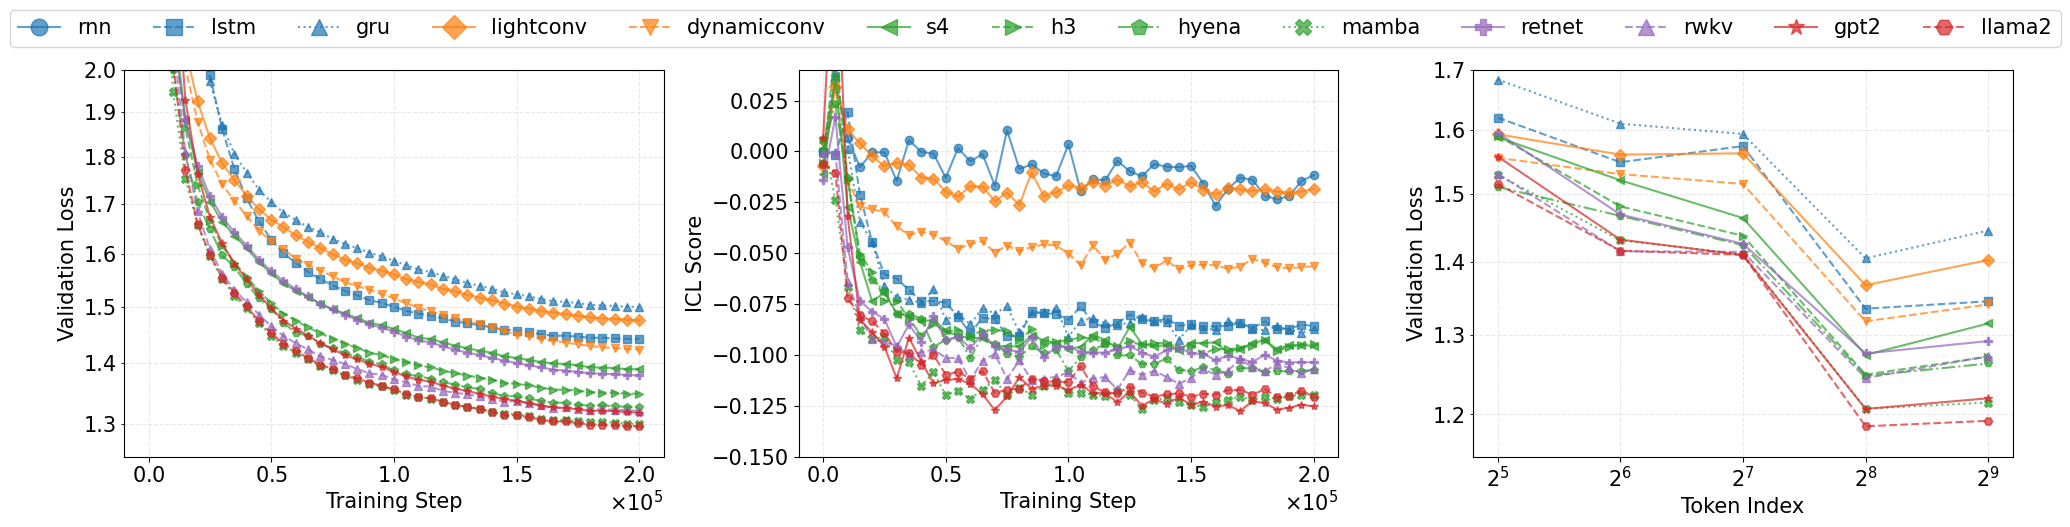

In [9]:
plt.rcParams.update({'font.size': 15})

### plot validation loss over time for each model
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
gb = df.groupby("model")
# sort gb by legend order
gb = sorted(gb, key=lambda x: legend_order.index(x[0]))
ax = axes[0]
for model, group in gb:
    ax.plot(group["_step"], group[METRIC_AVG_VAL], label=model, **style_map[model], alpha=0.7)
ax.set_xlabel("Training Step")
ax.set_ylabel("Validation Loss")
# set y-axis to log scale
# increase frequency of y ticks
ax.grid(True, linestyle="--", which="both", color="lightgrey", alpha=0.5)

# Set x-axis ticks
formatter = ScalarFormatter(useMathText=True)  # useMathText=True will use 'math text' for the notation
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))  # You can adjust these limits based on your data range
ax.xaxis.set_major_formatter(formatter)

# Set the y-axis to log scale with the base e
ax.set_yscale('log')
ax.set_ylim(1.25, 2)

# remove scientific notation from y-axis
ax.yaxis.set_minor_formatter(ScalarFormatter())

### Plot ICL score versus training step
ax2 = axes[1]
gb = df.groupby("model")
# sort gb by legend order
gb = sorted(gb, key=lambda x: legend_order.index(x[0]))
for model, group in gb:
    ax2.plot(group["_step"], group[ICL_SCORE_LONG], label=model, **style_map[model], alpha=0.7)
ax2.set_xlabel("Training Step")
ax2.set_ylabel("ICL Score")
ax2.set_ylim(-0.15, 0.04)

# Set x-axis ticks
formatter = ScalarFormatter(useMathText=True)  # useMathText=True will use 'math text' for the notation
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))  # You can adjust these limits based on your data range
ax2.xaxis.set_major_formatter(formatter)

ax2.grid(True, linestyle="--", which="both", color="lightgrey", alpha=0.5)

### plot validation loss versus token index
df_max_step = df.loc[df.groupby(["model"])["_step"].idxmax()]
df_max_step = df_max_step.sort_values("model")
df_max_step = df_max_step.reset_index(drop=True)
def post_process(df):
    df = df.copy()
    df[METRIC_TOK_VAL] = df[METRIC_TOK_VAL].apply(np.array)
    df['val_tok_len'] = df[METRIC_TOK_VAL].apply(len)
    df['val_tok_pow2'] = df[METRIC_TOK_VAL].apply(extract_pow2_accs)
    # truncate 'val_tok_pow2' to last 5 elements
    df['val_tok_pow2'] = df['val_tok_pow2'].apply(lambda x: x[-5:])
    
    return df
df_max_step = post_process(df_max_step)
ax = axes[2]
for model in legend_order:
    row = df_max_step.loc[df_max_step['model'] == model]
    if row.empty:
        continue
    ax.plot(row['val_tok_pow2'].iloc[0], label=model, **style_map[model], alpha=0.7)
ax.grid(True, linestyle="--", which="both", color="lightgrey", alpha=0.5)
# log scale
ax.set_yscale("log")
ax.set_ylim(1.15, 1.7)

# Set x axis to powers of 2^0 ... 2^9
ax.set_xticks(np.arange(5), [f"$2^{{{i}}}$" for i in range(5, 10)])
# increase frequency of y ticks
# ax.set_yticks(np.arange(1, 4.5, 0.5))
# y axis label Validation Loss
ax.set_ylabel("Validation Loss")
# x axis label Number of Tokens
ax.set_xlabel("Token Index")

# remove scientific notation from y-axis
ax.yaxis.set_minor_formatter(ScalarFormatter())
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(df['model'].unique()), bbox_to_anchor=(0.5, 1.08), markerscale=2)

plt.tight_layout()
plt.show()


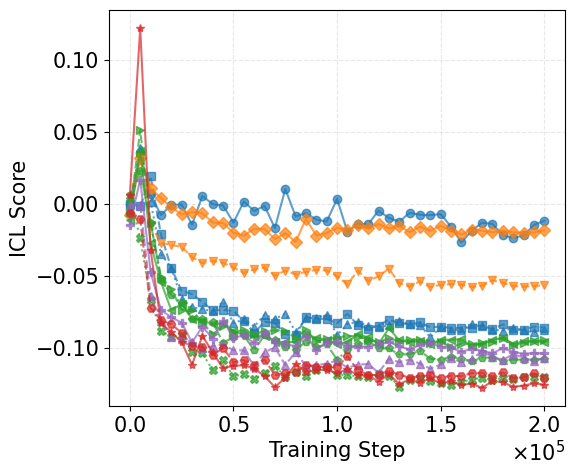

In [10]:
# ICL score versus training step
fig, ax = plt.subplots(figsize=(6, 5))
gb = df.groupby("model")
# sort gb by legend order
gb = sorted(gb, key=lambda x: legend_order.index(x[0]))
for model, group in gb:
    ax.plot(group["_step"], group[ICL_SCORE_LONG], label=model, **style_map[model], alpha=0.7)
ax.set_xlabel("Training Step")
ax.set_ylabel("ICL Score")

# Set x-axis ticks
formatter = ScalarFormatter(useMathText=True)  # useMathText=True will use 'math text' for the notation
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 1))  # You can adjust these limits based on your data range
ax.xaxis.set_major_formatter(formatter)

ax.grid(True, linestyle="--", which="both", color="lightgrey", alpha=0.5)
# ax2.legend()
plt.tight_layout()
plt.show()

In [11]:
# filter the df to only include the row with the max _step value for each model
df_max_step = df.loc[df.groupby(["model"])["_step"].idxmax()]
df_max_step = df_max_step.sort_values("model")
df_max_step = df_max_step.reset_index(drop=True)
# convert the _step column to list
df_max_step

,_step,eval-eval.per_token_loss,eval-eval.loss,eval-eval.long_icl_score,eval-eval.short_icl_score,model,model.n_layer,model.d_model,run_id
0,200000,"[3.809602975845337, 3.079890489578247, 2.70935...",1.423474,-0.056462,-0.052586,dynamicconv,7,640,nzgxfkws
1,200000,"[3.853205680847168, 3.1188056468963623, 2.7572...",1.318315,-0.125403,-0.125114,gpt2,8,576,o2khttk2
2,200000,"[3.8367745876312256, 3.1643311977386475, 2.786...",1.499076,-0.087299,-0.080085,gru,5,1024,y529vtod
3,200000,"[3.8171958923339844, 3.0890393257141113, 2.732...",1.349144,-0.094620,-0.100228,h3,7,1024,q42d7g23
4,200000,"[3.8040475845336914, 3.0411949157714844, 2.686...",1.326991,-0.107324,-0.109780,hyena,8,576,v2l4ykuh
5,200000,"[3.81893253326416, 3.0691657066345215, 2.72989...",1.475203,-0.018392,-0.019946,lightconv,5,768,xo1fvrat
6,200000,"[3.858969211578369, 3.0804262161254883, 2.7274...",1.296861,-0.120562,-0.123280,llama2,8,512,ii4pewcb
7,200000,"[3.835465431213379, 3.095425605773926, 2.76315...",1.442031,-0.085820,-0.074833,lstm,5,896,gw1lk6dq
8,200000,"[3.8131661415100098, 3.077061653137207, 2.6944...",1.300297,-0.119863,-0.119981,mamba,8,800,0sncxu66
9,200000,"[3.850498676300049, 3.1123745441436768, 2.7660...",1.379708,-0.103734,-0.116584,retnet,8,512,9n65h4xw


In [12]:
type(df_max_step['eval-eval.per_token_loss'].iloc[0])

list

In [13]:
def post_process(df):
    df = df.copy()
    df[METRIC_TOK_VAL] = df[METRIC_TOK_VAL].apply(np.array)
    df['val_tok_len'] = df[METRIC_TOK_VAL].apply(len)
    df['val_tok_pow2'] = df[METRIC_TOK_VAL].apply(extract_pow2_accs)
    # df['val_tok_pow2_len'] = df['val_tok_pow2'].apply(len)    
    
    return df
df_max_step = post_process(df_max_step)
df_max_step.head()

,_step,eval-eval.per_token_loss,eval-eval.loss,eval-eval.long_icl_score,eval-eval.short_icl_score,model,model.n_layer,model.d_model,run_id,val_tok_len,val_tok_pow2
0,200000,"[3.809602975845337, 3.079890489578247, 2.70935...",1.423474,-0.056462,-0.052586,dynamicconv,7,640,nzgxfkws,512,"[3.809602975845337, 3.079890489578247, 2.48669..."
1,200000,"[3.853205680847168, 3.1188056468963623, 2.7572...",1.318315,-0.125403,-0.125114,gpt2,8,576,o2khttk2,512,"[3.853205680847168, 3.1188056468963623, 2.5357..."
2,200000,"[3.8367745876312256, 3.1643311977386475, 2.786...",1.499076,-0.087299,-0.080085,gru,5,1024,y529vtod,512,"[3.8367745876312256, 3.1643311977386475, 2.569..."
3,200000,"[3.8171958923339844, 3.0890393257141113, 2.732...",1.349144,-0.094620,-0.100228,h3,7,1024,q42d7g23,512,"[3.8171958923339844, 3.0890393257141113, 2.509..."
4,200000,"[3.8040475845336914, 3.0411949157714844, 2.686...",1.326991,-0.107324,-0.109780,hyena,8,576,v2l4ykuh,512,"[3.8040475845336914, 3.0411949157714844, 2.467..."


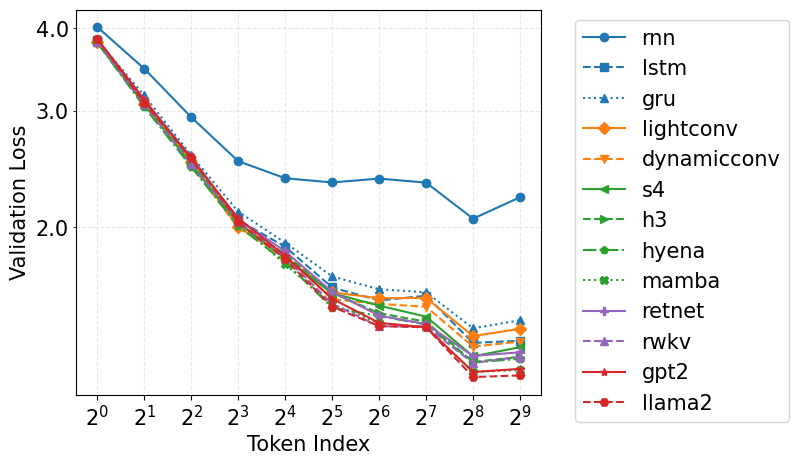

In [14]:
# validation loss versus number of tokens
plt.figure(figsize=(6, 5))
for model in legend_order:
    row = df_max_step.loc[df_max_step['model'] == model]
    if row.empty:
        continue
    plt.plot(row['val_tok_pow2'].iloc[0], label=model, **style_map[model])
plt.grid(True, linestyle="--", which="both", color="lightgrey", alpha=0.5)
# log scale
plt.yscale("log")
# plt.ylim(1, 4)

# Set x axis to powers of 2^0 ... 2^9
plt.xticks(np.arange(10), [f"$2^{{{i}}}$" for i in range(10)])
# y axis label Validation Loss
plt.ylabel("Validation Loss")
# x axis label Number of Tokens
plt.xlabel("Token Index")

# remove scientific notation from y-axis
ax = plt.gca()
ax.yaxis.set_minor_formatter(ScalarFormatter())

# # increase frequency of y ticks
# ax = plt.gca()
# # Define major and minor locators for the y-axis
# major_locator = LogLocator(base=2.0, numticks=50) # Adjust 'numticks' as needed
# minor_locator = LogLocator(base=2.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=50)

# # Set major and minor locators
# ax.yaxis.set_major_locator(major_locator)
# ax.yaxis.set_minor_locator(minor_locator)

plt.legend()
# shrink legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
